# Masterthesis

---

## Description

Alexander Henoch

conda install jedi=0.17.2 jupyterlab jupyter-resource-usage nodejs umap-learn=0.4.6 hdbscan=0.8.26 pandas progressbar2 plotnine joblib=0.17.0

| Name | Version | Build | Channel |
| -------------------- | ------- | ------------------ | ----------- |
| hdbscan | 0.8.26 | py38h0b5ebd8_3 | conda-forge |
| jedi | 0.17.2 | py38h578d9bd_1 | conda-forge |
| jupyter-resource-usage | 0.5.1 | pyhd8ed1ab_0 | conda-forge |
| jupyterlab | 3.0.5 | pyhd8ed1ab_0 | conda-forge |
| nodejs | 15.3.0 | h25f6087_0 | conda-forge |
| pandas | 1.2.1 | py38h51da96c_0 | conda-forge |
| plotnine | 0.7.1 | py_0 | conda-forge |
| progressbar2 | 3.53.1 | pyh9f0ad1d_0 | conda-forge |
| umap-learn | 0.4.6 | py38h32f6830_0 | conda-forge |


---

## To-Do

1. [X] Frequency extraction 
2. [ ] Clustering UMAP/HDB
    1. [X] Parameter exploration
    2. [ ] Cluster number reduction
    3. [ ] Centroid extraction
    4. [ ] New Subtype Classification
3. [ ] Subtype interaction matrix
    1. [ ] Iteraction counting
4. [ ] Alignment
5. [ ] Circle hunt
6. [ ] Mutations
7. [ ] Write Thesis

---

## Introduction

1. Virus/Pandemia
2. Influenza/Danger
3. Segments/Subtypes
4. Sequencing/NTs/AAs/Mutations
5. Clustering/-methods/Hierarchical/HDB
6. K-mer Frequencies/Dimensions/UMAP
7. Linkage Trees/define k/Parameter
8. ...
9. biol. Subtypes/new Subtypes?
10. Alignments/Structures
11. Thesis

---

## Methods

1. 
2. UMAP/HDB/hybrid clustering
3. Metrices/Scorings/DBCV/Epsilon/treecutting
4. 

---

## Results and Discussion

1. 
2. DBCV/Epsilon (Plot)
3. cluster density (Plot)
4. cluster + linkage tree(?)
5. subtypes?
6. 

---

### Package import

- numpy, pandas: Dataframes
- sys, re, csv, time: Python core functions
- collections, itertools: Extended core functions
- umap, hdbscan: Clustering
- plotnine, matplotlib inline: Plotting 

---

In [1]:
import numpy as np
import pandas as pd
import sys
import re
import csv
import collections as co
import itertools as it
import umap
import hdbscan
import time 
import progressbar
from plotnine import *
%matplotlib inline

### K-mer Frequency calculation

- my frequency class
    - max possible RAM save
    - creation of matrix beforehand (adjustment)
        - runtime + / RAM -
    - no concatenation /copy of data -> more RAM)
        - filling existing matrix
        - has to be in the exact right size!
    - Ns frequency
        - ...
    - AAs with Ns
        - ...
    
---

In [2]:
class frequency(object):
    
    def __init__(self, k = 7, convert = 0):
    
        self.k = k
        self.convert = convert
        self.exist = co.defaultdict(int) 
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.row = 0
        self.matrix = np.empty((self.row, self.col, ),dtype = "float32")
        self.amino = co.defaultdict(str, {
            'AAA':'K', 'AAC':'N', 'AAG':'K', 'AAT':'N',
            'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
            'AGA':'R', 'AGC':'S', 'AGG':'R', 'AGT':'S',
            'ATA':'I', 'ATC':'I', 'ATG':'M', 'ATT':'I',
            'CAA':'Q', 'CAC':'H', 'CAG':'Q', 'CAT':'H',
            'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
            'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
            'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
            'GAA':'E', 'GAC':'D', 'GAG':'E', 'GAT':'D',
            'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
            'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
            'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',    
            'TAA':'Y', 'TAC':'*', 'TAG':'*', 'TAT':'Y',
            'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
            'TGA':'*', 'TGC':'C', 'TGG':'W', 'TGT':'C',
            'TTA':'L', 'TTC':'F', 'TTG':'L', 'TTT':'F'
        })
                
    def translate(self, read):
    
        chain = ''

        for i in range(len(read) - 2):
            trip = read[i:i+3]
            chain += self.amino[trip]

        return(chain)
    
    
    def adjust_to_data(self, infile):
    
        self.row = infile.shape[0]
            
        for line, read in infile.itertuples(index=True, name=None):

            if self.convert == 1:
                seq = self.translate(read)
                del read

                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    self.exist[kmer] = 0

            else:
                seq = read
                del read

                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        self.exist[kmer] = 0
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            self.exist[kmer] = 0
            
        self.keys = list(self.exist.keys())
        self.col = len(self.keys)
        self.matrix = np.empty((self.row, self.col, ), dtype="float32")
        
        del seq
    
    
    def calculate_frequence(self, infile):
        
        for line, read in infile.itertuples(index=True, name=None): 
                 
            if self.convert == 1:
                seq = self.translate(read)
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                for i in range(num):
                    kmer = seq[i:i+self.k]
                    counts[kmer] += 1

            else:
                seq = read
                del read

                counts = self.exist.copy()
                num = len(seq) - self.k + 1

                if re.match('^[ACGT]*$', seq): 
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        counts[kmer] += 1
                else:
                    for i in range(num):
                        kmer = seq[i:i+self.k]
                        if re.match('^[ACGT]*$', kmer): 
                            counts[kmer] += 1

            vector = np.array(list(counts.values()), dtype = "float32")/num

            self.matrix[line] = vector
            
            counts.clear()
            del vector
            del seq
            del counts
    
    
    def get_keys(self):
        
        return(self.keys)
    
    
    def get_matrix(self):
        
        return(self.matrix)

### Frequency Vector Dimension reduction

- n neighbors:
    - difficult
    - below 50 = ~400 **very good** clusters
    - around 100 = ~250 **good** clusters
    - above 200 = ~150 **mediocre** clusters
- min. dist:
    - less as possible for better seperation in dimension reduction
    - 0.1 creates more noise than 0.0
- n components:
    - the higher the resulting dimension the more time is needed for HDB clustering
- random state:
    - 42 answer on everything in the universe
    - completely **useless** parameter
- metric:
    - seems to have very little effect on the **euclidean** clustering of HDB
- frequency:
    - removed frequency of AA chain
    - *way better results*
    
---

In [3]:
def get_vectors(sequence, accession):

    freq = frequency(k = 7, convert = 0)
    freq.adjust_to_data(sequence)
    freq.calculate_frequence(sequence)

    matrix = freq.get_matrix()
    keys = freq.get_keys()

    #Dimension Reduction with UMAP

    reduced = umap.UMAP(
        n_neighbors = 100,
        min_dist = 0.0,
        n_components = 20,
        random_state = 42,
        #metric = 'cosine',
    ).fit_transform(matrix)

    dataframe = pd.concat([accession, pd.DataFrame(reduced)], axis=1, copy = False, ignore_index = False).set_index('accession')
    
    return(dataframe)

### DBCV and Epsilon Cutoff Discovery

- **HDB scan don't necessarily create round clusters**
    - calculations based on round clusters are useless
    - centroid calculation difficult
    - inner cluster distances wrong
    - silhouette score wrong
        - look [here](https://pberba.github.io/stats/2020/01/17/hdbscan/)
- DBCV and Epsilon
    - Epsilon:
        - Hybrid clustering with DBSCAN* and HDBSCAN*
        - look [here](https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html)
    - DBCV:
        - Density Based Cluster Validity (DBCV) score
        - [paper](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf)
        - needs minimum spanning tree (parameter = True)
    - loop to increse Epsilon by comparison with the DBCV score
    - *seems to be promising*
- centroids:
    - *maybe by extraction exemplars and connect them single linkage wise*
    - *~13000 exemplars and 13000 clusters -> 250 clusters*
    - *how to shrink number of exemplars*
- removed reinitialisation of lists to save all values
- unclustered and cluster number removed and integrated in final clustering

---

In [4]:
def get_epsilon(dataframe):
    
    epsilon = 0.0
    dbcv_list = []
    #n_cluster_list = []
    #unclustered_list = []
    epsilon_list = []

    clusterer_init = hdbscan.HDBSCAN(
        min_samples = 1,
        min_cluster_size = 2,
        cluster_selection_epsilon = 0.0,
        gen_min_span_tree=True,
    ).fit(dataframe)

    epsilon_max = clusterer_init.single_linkage_tree_.to_pandas()['distance'].max().item()

    while epsilon <= epsilon_max:

        clusterer = hdbscan.HDBSCAN(
            min_samples = 1,
            min_cluster_size = 2,
            cluster_selection_epsilon = epsilon,
            gen_min_span_tree=True,
        ).fit(dataframe)

        dbcv_list.append(clusterer.relative_validity_.item())
        label = list(clusterer.labels_)
        #n_cluster_list.append(len(set(label))-1)
        #unclustered_list.append(label.count(-1))
        epsilon_list.append(epsilon)

        epsilon = round(epsilon + 1.0, 2)

    epsilon_best = epsilon_list[dbcv_list.index(max(dbcv_list))]

    #print(f"First rough iteration:")
    #print(f"Best DBCV value: {max(dbcv_list)}")
    #print(f"Cluster number: {n_cluster_list[dbcv_list.index(max(dbcv_list))]}")
    #print(f"Unclustered/Noise: {unclustered_list[dbcv_list.index(max(dbcv_list))]}")

    epsilon = round(epsilon_best - 1.0, 2)

    if (epsilon < 0.0):
        epsilon = 0.0

    epsilon_max = round(epsilon_best + 1.0, 2)
    #dbcv_list = []
    #n_cluster_list = []
    #unclustered_list = []
    #epsilon_list = []

    #DBCV Exploration (fine)

    while epsilon <= epsilon_max:

        clusterer = hdbscan.HDBSCAN(
            min_samples = 1,
            min_cluster_size = 2,
            cluster_selection_epsilon = epsilon,
            gen_min_span_tree=True,
        ).fit(dataframe)

        dbcv_list.append(clusterer.relative_validity_.item())
        label = list(clusterer.labels_)
        #n_cluster_list.append(len(set(label))-1)
        #unclustered_list.append(label.count(-1))
        epsilon_list.append(epsilon)

        epsilon = round(epsilon + 0.1, 2)

    dbcv_best = max(dbcv_list)
    epsilon_best = epsilon_list[dbcv_list.index(dbcv_best)]
    parameter = pd.DataFrame(zip(epsilon_list, dbcv_list), columns = ['epsilon', 'DBCV']).set_index('epsilon')
    
    #print(f"Second fine iteration:")
    #print(f"Best DBCV value: {max(dbcv_list)}")
    #print(f"Cluster number: {n_cluster_list[dbcv_list.index(max(dbcv_list))]}")
    #print(f"Unclustered/Noise: {unclustered_list[dbcv_list.index(max(dbcv_list))]}")
    
    return(parameter, epsilon_best, dbcv_best)

### Clustering using optimized Epsilon

- Final clustering
    - *is the clustering the best possible?*
    - min. samples: the higher the more conservative = more noise = more unclustered
    - min. clustersize: value small? some very special influenza strains should be in small clusters
        - *maybe increase*
    - selection method?
        - HDB hybrid pager is a comparison and eom seems to be more matching

---

In [6]:
def get_cluster(epsilon_best, dataframe, extra, accession):

    clusterer_best = hdbscan.HDBSCAN(
        min_samples = 1,
        min_cluster_size = 2,
        cluster_selection_epsilon = epsilon_best,
        gen_min_span_tree=True,
        cluster_selection_method = 'eom',
    ).fit(dataframe)

    label = clusterer_best.labels_
    label_list = label.tolist()
    
    n_cluster = len(set(label_list))-1
    unclustered = label_list.count(-1)
    
    cluster = pd.concat([pd.DataFrame(label, columns = ['cluster']), extra, accession], axis=1, copy = False).set_index('accession')
    
    N_unmatch = cluster.groupby('cluster').filter(lambda x: x['N'].nunique() > 1).cluster.nunique()
    H_unmatch = cluster.groupby('cluster').filter(lambda x: x['H'].nunique() > 1).cluster.nunique() 
    
    return(cluster, n_cluster, unclustered, H_unmatch, N_unmatch)

### Plotting DBCV as a Function of Epsilon

- grafical representation of DBCV as a function of Epsilon

---

In [8]:
def plot_dbcv(parameter):

    plot = (ggplot(parameter, aes(x="epsilon", y='DBCV', colour = "factor(segment)")) 
     + labs(
        x="Epsilon",
        y="DBCV",
        colour="Segment",
        title="DBCV by changing Epsilon",
     )
     + geom_line()
     #+ geom_vline(aes(xintercept = epsilon_best))
     + scale_x_continuous()
     + scale_y_continuous()
     + facet_wrap('~segment', ncol = 4)
     + theme_538()
    )
    
    return(plot)

### Plotting Cluster Size Distribution

- legend position better on right side
    - bottom legend overlays axis

---

In [9]:
def plot_density(cluster):

    density = pd.DataFrame(cluster.value_counts(subset=['segment', 'cluster']), columns = ['size'])
    density.reset_index(level = ["segment", "cluster"], inplace=True)

    plot = (ggplot(density, aes(x="size", colour = "factor(segment)", fill = "factor(segment)")) 
     + labs(
        x="Cluster Size",
        y="Density",
        fill="Segment",
        colour="Segment",
        title="Cluster Size Distribution",
     )
     + geom_density(alpha = 0.25)
     + scale_x_log10()
     + scale_y_continuous()
     + facet_wrap('~segment', ncol = 4)
     + theme_538()
    )
    
    return(plot)

### Clustering Results

In [10]:
def subsplit(subtype):
    if re.match('^[H][0-9]+N[0-9]+$', subtype): 
        H = re.search('[H][0-9]+', subtype).group(0)
        N = re.search('[N][0-9]+', subtype).group(0)
    else:
        H = np.nan
        N = np.nan
    return(H, N)

 [elapsed time: 0:31:46] |##################################| (Time:  0:31:46) 


         n_cluster  unclustered  H_unmatch  N_unmatch  epsilon_best  dbcv_best
segment                                                                       
1              247            0         98        100           2.5   0.800712
2              237            0         84         87           2.0   0.808490


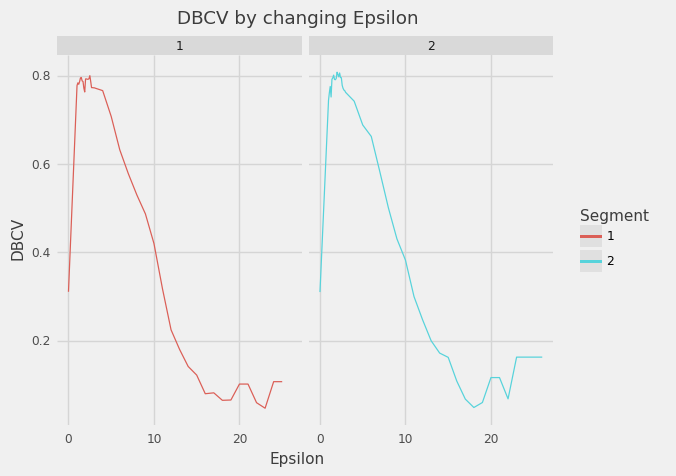

<ggplot: (8743623852710)>


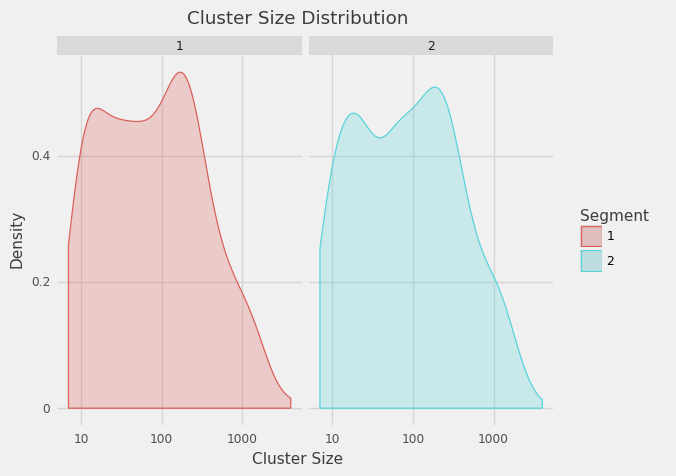

<ggplot: (8743624112198)>
           segment  cluster   H   N                   strain
accession                                                   
>CY021716        1      133  H1  N1         A/AA/Huston/1945
>CY020292        1      133  H1  N1         A/AA/Marton/1943
>CY083917        1       21  H1  N1    A/Aalborg/INS132/2009
>CY063613        1       21  H1  N1    A/Aalborg/INS133/2009
>CY073732        1       21  H1  N1    A/Aalborg/INS283/2009
...            ...      ...  ..  ..                      ...
>KM374040        2      141  H7  N9     A/Zhejiang/LS01/2014
>CY095719        2      178  H1  N1       A/Zhejiang/X1/2009
>CY095746        2      178  H1  N1       A/Zhejiang/X2/2009
>KF007058        2      141  H7  N9       A/Zhenjiang/1/2013
>KU217322        2      212  H9  N2  A/Zhongshan/201501/2015

[110728 rows x 5 columns]


In [11]:
parameter_dict = co.defaultdict(list)
cluster_dict = co.defaultdict(list)
information_dict = co.defaultdict(list)

upload = pd.read_csv('A.csv', sep = ',', na_filter = False, header = None)
upload.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation', 'genome']
upload.query('curation == "Pass"', inplace = True)
upload[['H', 'N']] = upload.subtype.apply(lambda x: subsplit(x)).tolist()

segments = [1, 2, 3, 4, 5, 6, 7, 8]
widgets = [' [', progressbar.Timer(format = 'elapsed time: %(elapsed)s'), '] ', progressbar.Bar('#'),' (', progressbar.ETA(), ') ', ] 
bar = progressbar.ProgressBar(max_value = len(segments), widgets = widgets).start() 

for segment in segments:
    
    subset = upload.query('segment == @segment').reset_index()
    sequence = subset[['genome']].copy()
    accession = subset[['accession']].copy()
    extra = subset[['H', 'N', 'strain']].copy()

    dataframe = get_vectors(sequence, accession)
    parameter_dict[segment], epsilon_best, dbcv_best = get_epsilon(dataframe)
    cluster_dict[segment], n_cluster, unclustered, H_unmatch, N_unmatch = get_cluster(epsilon_best, dataframe, extra, accession)
    information_dict[segment] = [n_cluster, unclustered, H_unmatch, N_unmatch, epsilon_best, dbcv_best]
    
    bar.update(segment)

bar.finish()    

cluster = pd.concat(cluster_dict)
cluster.index.set_names(["segment", "accession"], inplace=True)
cluster.reset_index(level = "segment", inplace=True)

parameter = pd.concat(parameter_dict)
parameter.index.set_names(["segment", "epsilon"], inplace=True)
parameter.reset_index(level = ["segment", "epsilon"], inplace=True)

information = pd.DataFrame.from_dict(information_dict, orient='index', columns=['n_cluster', 'unclustered', 'H_unmatch', 'N_unmatch', 'epsilon_best', 'dbcv_best'])
information.index.set_names(["segment"], inplace=True)

print(information)
print(plot_dbcv(parameter))
print(plot_density(cluster))
print(cluster)

### Plotting Cluster Interactions

In [67]:
def plot_interactions(interaction, x, y):

    plot = (ggplot(interaction, aes(x="cluster_x", y="cluster_y"))
     + labs(
        x="Cluster Segment " + str(x),
        y="Cluster Segment " + str(y),
        #fill="Interactions",
        title="Segment Cluster Interactions",
     )
     + geom_bin2d(binwidth = 2.5)
     #+ geom_tile(aes(fill ="strain"))
     + scale_fill_gradient(low="lightgray", high="black", na_value='lightgray')
     + theme_538()
    )
    
    return(plot)

### Interaction Matrix Calculation

In [63]:
interaction_dict = co.defaultdict(tuple)
for x,y in it.combinations(segments, 2):
    
    interaction = pd.merge(
        cluster.query('segment == @x').reset_index('accession')[['cluster', 'strain']],
        cluster.query('segment == @y').reset_index('accession')[['cluster', 'strain']], 
        on='strain'
    )
    
    interaction_dict[(x,y)] = interaction
    #interaction_dict[(x,y)] = interaction.groupby(['cluster_x', 'cluster_y']).count().reset_index(['cluster_x', 'cluster_y'])
    #interaction_dict[(x,y)] = pd.crosstab(interaction.cluster_x, interaction.cluster_y, margins = True)

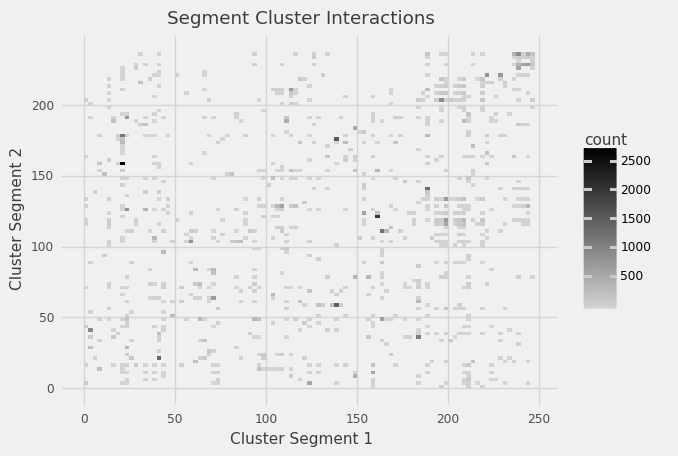

<ggplot: (8743624299126)>

In [68]:
plot_interactions(interaction_dict[(1,2)], 1, 2)